In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from math import *
from scipy.stats import mode

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score



from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin
import xgboost as xgb
import warnings
# warnings.filterwarnings('ignore')
import os



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\egeme\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
zs= 0.53

def accuracy_calculate(actual_values, predicted_values):
    comparison = abs(np.round(predicted_values) - actual_values)
    accuracy = 1- ((len(comparison[comparison>=(0+1)])) / len(actual_values))
    return accuracy

def mean_iou_calculator(actual_values, predicted_values, time):
    confusion_array = confusion_matrix(actual_values, predicted_values)
    individual_ious = []
    for i in range(len(confusion_array)):
        individual_iou = confusion_array[i][i] / (sum(confusion_array[i]))
        individual_ious.append(individual_iou)
    mean_iou = sum(individual_ious)/len(individual_ious)
    results = pd.DataFrame()  
    featue_y_values = sorted(data[time].unique())
    for i in range(len(individual_ious)):
        results.insert(0, 'iou_(' + str(featue_y_values[i])  +')', [individual_ious[i]], True)
    results = results[results.columns[::-1]]
    results.insert(0, 'mean_iou', mean_iou, True)
    return results

data = pd.read_csv('gulle.csv', sep=';', encoding = "utf8")
#Rearannge the dataframe as the old one
data.columns = ['product', 'amount', 'company', 'town', 'type', 'order date', 'delivery date', 'time']

data2 = data.drop('delivery date', axis = 1)
data2["order day"] = ''
data2["order month"] = ''
data2["week day"] = ''


# Remove 'order date' and add 'order day', 'order month' and 'week day' features
for i in range(len(data2)):
  data2.at[i, 'order day'] = data2['order date'][i].split()[0]
  data2.at[i, 'order month'] = data2['order date'][i].split()[1]
  data2.at[i, 'week day'] = data2['order date'][i].split()[-1]
data2 = data2.drop('order date', axis = 1)
data2['week day'] = data2['week day'].str.replace('Pazartesi','pts')
data2['week day'] = data2['week day'].str.replace('Salı','sal')
data2['week day'] = data2['week day'].str.replace('Çarşamba','çrş')
data2['week day'] = data2['week day'].str.replace('Perşembe','prş')
data2['week day'] = data2['week day'].str.replace('Cumartesi','cts')
data2['week day'] = data2['week day'].str.replace('Cuma','cum')
data2['week day'] = data2['week day'].str.replace('Pazar','paz')

# data2 = data2[data2["week day"].str.contains("Pazar") == False]

# Rearranging Dataframe
data2 = data2[['product', 'company', 'amount', 'town', 'type', 'order day', 'week day', 'order month', 'time']]
data2['town'] = data2['town'].str.lower()
data2['town'] = data2['town'].str.replace('i̇','i')
data2['town'] = data2['town'].str.replace('.','missing')
data2['town'] = data2['town'].str.replace(' tekirdağ','tekirdağ')
data2['town'] = data2['town'].str.replace('küçükçekmece','istanbul')
data2['town'] = data2['town'].str.replace('çorlu','tekirdağ')
data2['town'] = data2['town'].str.replace('bandirma','balıkesir')

#data2 = data2.drop('town',axis = 1).reset_index(drop=True)
data2 = data2.drop('order day',axis = 1).reset_index(drop=True)
#data2 = data2.drop('order month',axis = 1).reset_index(drop=True)
data2 = data2.fillna("missing")
#data2 = data2[data2["town"].str.contains("missing") == False]

data_clean = data2.copy()
drop_df = data2.copy()
drop_index_list = []


########################################################################################### REMOVE INSUFFICIENT DATA
def remove_insuff(df, ft):
    print("removing insufficient data for ", ft, "...")
    fst_len = len(df)
    x = df[ft].value_counts() < 10
    df2 = x.to_frame().reset_index()
    df2.columns = [ft, 'booly']
    df2.drop(df2[df2.booly == False].index, inplace=True)
    drop_list = df2[ft].tolist()
    drop_indices=[]

    if len(drop_list) != 0:
        for i in df.index:
            for j in range(len(drop_list)):
                if (drop_list[j] == df.at[i, ft]):
                    drop_indices = drop_indices + [i]
        df.drop(drop_indices, inplace=True)
        
    else:
        drop_indices = []
                        
    lst_len = len(df)
    rem = fst_len - lst_len      # number of removed data
    per = (rem / fst_len) * 100  # percentage of removed data

    print("total number of removed data: ", rem)
    print("persentage of removed data: ", round(per, 2), "%")
    return df, drop_indices

data2, drop_indices = remove_insuff(data2, "company")
drop_index_list = drop_index_list + drop_indices

data2, drop_indices = remove_insuff(data2, "product")
drop_index_list = drop_index_list + drop_indices


########################################################################################### CLEAN NOISE
def clean_noise(df): 
    in_len = len(df)
    zs = 0.89
    
    n_prod = df["product"].nunique()
    prod_list = df["product"].unique()
    n_comp = df["company"].nunique()
    comp_list = df["company"].unique()
    
    print("Cleaning noise ... ")
    
    index_drop_list = []
    for prod in prod_list:

        df_max_scaled = df[df["product"] == prod].copy()

        for comp in comp_list:
            df_max_scaled2 = df_max_scaled[df_max_scaled["company"] == comp].copy()

            if len(df_max_scaled2) > 1:
                
                max_min_t = df_max_scaled2["time"].max() - df_max_scaled2["time"].min()
                max_min_a = df_max_scaled2["amount"].max() - df_max_scaled2["amount"].min()
                
                if (max_min_a != 0) and (max_min_t != 0):
                    df_max_scaled2["time"] = (df_max_scaled2["time"] - df_max_scaled2["time"].min()) / max_min_t
                    t_sc = df_max_scaled2[["time"]]
                    df_zscore_t = (t_sc - t_sc.mean())/t_sc.std()
                    dfz_t = abs(df_zscore_t) > zs

                    df_max_scaled2["amount"] = (df_max_scaled2["amount"] - df_max_scaled2["amount"].min()) / max_min_a
                    amo_sc = df_max_scaled2["amount"]
                    df_zscore_a = (amo_sc - amo_sc.mean())/amo_sc.std()
                    dfz_a = abs(df_zscore_a) > zs

                    df1 = dfz_t["time"] & dfz_a 
                    df2 = (df_zscore_t["time"] * df_zscore_a) < 0 
                    dfz = df1 & df2 

                    index_drop_list = index_drop_list + [*filter(dfz.get, dfz.index)]

    index_drop_list = sorted(list(set(index_drop_list)))
    df.drop(index_drop_list, axis=0, inplace=True)
    rem = len(index_drop_list)
    f_len = len(df)
    n_del = in_len - f_len
    per = (n_del / in_len) * 100
    
    print("deleted indices: ",index_drop_list)
    print("total number of removed data: ", n_del)
    print("persentage of removed data: ", round(per, 2), "%")
    
    return df, index_drop_list

def clean_noise_tt(df): 
    in_len = len(df)
    zst = 1.2
    
    n_prod = df["product"].nunique()
    prod_list = df["product"].unique()
    n_comp = df["company"].nunique()
    comp_list = df["company"].unique()
        
    print("Cleaning noise ... ")
    
    index_drop_list = []
    for prod in prod_list:

        df_max_scaled = df[df["product"] == prod].copy()

        for comp in comp_list:
            df_max_scaled2 = df_max_scaled[df_max_scaled["company"] == comp].copy()

            if len(df_max_scaled2) > 1:
                
                max_min_t = df_max_scaled2["time"].max() - df_max_scaled2["time"].min()
                
                if (max_min_t != 0):
                    df_max_scaled2["time"] = (df_max_scaled2["time"] - df_max_scaled2["time"].min()) / max_min_t
                    t_sc = df_max_scaled2[["time"]]
                    df_zscore_t = (t_sc - t_sc.mean())/t_sc.std()
                    dfz_t = abs(df_zscore_t) > zst
                    
                    index_drop_list += dfz_t[dfz_t["time"].eq(True)].index.tolist()
                    
                    #index_drop_list = index_drop_list + [*filter(dfz_t.get, dfz_t.index)]

    index_drop_list = sorted(list(set(index_drop_list)))
    df.drop(index_drop_list, axis=0, inplace=True)
    rem = len(index_drop_list)
    f_len = len(df)
    n_del = in_len - f_len
    per = (n_del / in_len) * 100
    
    print("deleted indices: ",index_drop_list)
    print("total number of removed data: ", n_del)
    print("persentage of removed data: ", round(per, 2), "%")
    
    return df, index_drop_list

pd.options.mode.chained_assignment = None

data2, train_drop_list = clean_noise(data2)
drop_index_list = drop_index_list + train_drop_list

data2, train_drop_list = clean_noise_tt(data2)
drop_index_list = drop_index_list + train_drop_list


########################################################################################### GROUP TIME
def group_time(df):
    
    min_samp = len(df)*0.07 #len(df)*0.07
    t = 1
    gs = 0
    group = []
    sub_group = [t]
    #gap = df["time"].std()

    while t <= df["time"].max():
        
        
        if sum(df["time"] == t) > 0:
        
            gs += sum(df["time"] == t)

            if (len(sub_group) > 0) and ((t - min(sub_group)) <= math.ceil(math.sqrt(min(sub_group)))):
                sub_group += [t]

            else:
                if (len(sub_group) != 0):
                    gs = 0
                    group += [sub_group]
                sub_group = [t]

            if (gs >= min_samp) or ((t - min(sub_group)) > math.ceil(math.sqrt(min(sub_group)))):
                gs = 0
                group += [sub_group]
                sub_group = []
                
        if t == df["time"].max() :
            group += [sub_group]
            group[0].remove(1)
            
            c = True               # son sub_grouptan bir önceki sub_groupa time aktarımı
            gap = group[-2][0]     # son sub_grouptan bir önceki sub_groupa yollanan time değerleri arasındaki maksimum fark 
            while c:
                if len(group[- 1]) >= 2:
                    x = group[-1][0]
                    x_l = group[-2] [-1]
                    x_r = group[-1] [1]

                    if (x - group[-2][0]) <= math.ceil(math.sqrt(group[-2][0])):
                        group[-2].append(x)
                        group[-1].remove(x)
                
                x = group[-1][0]
                if (x - group[-2][0]) <= math.ceil(math.sqrt(group[-2][0])):
                    group[-2].append(x)
                    group[-1].remove(x)
                    
                else:
                    c = False
            
            c = True     # son sub_groupta bulunan zamanlar dataframede 5 kereden az bulunuyorsa bu sub_groupu sil
            insuff_time = []
            while c:
                s = 0
                for i in range(len(group[-1])):
                    s += sum(df["time"] == group[-1][i])
                if s < 5:
                    insuff_time += group.pop(-1)
                else:
                    c = False

        t += 1
        
    return group, insuff_time

groups, insuff_time = group_time(data2)


########################################################################################### MAP TIME
def map_time(df, groups, insuff_time):
    print("Mapping time")
    index_drop_list = []
    for i in df.index:
        for t in insuff_time:
            if df.at[i, "time"] == t:
                index_drop_list += [i]
                
    df.drop(index_drop_list, axis=0, inplace=True)

    time = 0
    for sub_group in groups:
        time += 1
        for t in sub_group:
            for i in df.index:
                if df.at[i, "time"] == t:
                    df.at[i, "time"] = time
    return df
            
map_time(data2, groups, insuff_time)


########################################################################################### ONE HOT ENCODING
def one_hot(df, ft):      ### ft = "company", "product", "week day" etc.
    print("one hot encoding ", ft, "...")
    dum = pd.get_dummies(df[ft])
    df = df.drop(ft, axis = 1)
    df = df.join(dum)
    print(ft, "encoded.")
    return df

data2  = one_hot(data2, "week day")
data2  = one_hot(data2, "company")
data2  = one_hot(data2, "product")
data2  = one_hot(data2, "order month")


########################################################################################### DROP_DF & DATA_CLEAN
drop_index_list = sorted(list(set(drop_index_list)))
drop_df = drop_df.loc[drop_index_list]

data_clean.drop(drop_df.index.to_list(), axis=0, inplace=True)


########################################################################################### DROP TOWN COLUMN
data2 = data2.drop('town',axis = 1).reset_index(drop=True)


########################################################################################### TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split

X = data2.copy()
Y = data2.copy()
X.drop("time", axis=1, inplace=True)
Y = Y["time"]

x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.3, random_state = 42)


########################################################################################### NORMALIZE AMOUNT
xt_min = x_train["amount"].min()
xt_max = x_train["amount"].max()

x_train["amount"] = (x_train["amount"] - xt_min) / (xt_max - xt_min)
x_val["amount"] = (x_val["amount"] - xt_min) / (xt_max - xt_min)


########################################################################################### DF_EMPTY
df_empty = x_train[0:0]


########################################################################################### PCA
def do_pca(x_train, x_val):
    from sklearn.decomposition import PCA
    xl = len(x_train.columns)
    pca = PCA(.95)
    pca.fit(x_train)
    print("number of features dropped from ", xl, " to ", pca.n_components_) 
    #print("variance ratio: ", pca.explained_variance_ratio_) 

    x_train = pca.transform(x_train)
    x_val = pca.transform(x_val)
    return pca, x_train, x_val

pca, x_train, x_val = do_pca(x_train, x_val)

print("\ndone...")


C:\Users\egeme\AppData\Local\Temp\ipykernel_11008\4165551998.py:53: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data2['town'] = data2['town'].str.replace('.','missing')


removing insufficient data for  company ...
total number of removed data:  73
persentage of removed data:  6.54 %
removing insufficient data for  product ...
total number of removed data:  293
persentage of removed data:  28.09 %
Cleaning noise ... 
deleted indices:  [228, 255, 492, 494, 532, 547, 549, 564, 663, 701, 737, 744, 787, 956, 1024, 1037, 1088, 1089]
total number of removed data:  18
persentage of removed data:  2.4 %
Cleaning noise ... 
deleted indices:  [23, 34, 53, 91, 94, 103, 111, 114, 118, 135, 139, 185, 194, 195, 196, 197, 209, 218, 238, 247, 284, 286, 287, 292, 307, 308, 312, 316, 333, 336, 347, 394, 454, 458, 470, 540, 541, 552, 566, 628, 637, 655, 659, 675, 720, 728, 745, 746, 798, 807, 812, 839, 840, 851, 856, 871, 879, 882, 899, 914, 919, 947, 950, 975, 977, 981, 1005, 1035, 1065, 1066, 1082]
total number of removed data:  71
persentage of removed data:  9.7 %
Mapping time
one hot encoding  week day ...
week day encoded.
one hot encoding  company ...
company encod

In [3]:
groups


[[1], [2], [3], [4, 5], [6, 7, 9]]

In [4]:
X_train, y_train, X_test, y_test = x_train, y_train, x_val, y_val

In [5]:
seed=42
def KNobjective(params):
    nn = int(params['n_neighbors'])
    wt = params['weights']
    ls = int(params['leaf_size'])
    p_ = int(params['p'])
    clf = KNeighborsClassifier(n_neighbors=nn, weights=wt, leaf_size=ls, p=p_, n_jobs=-1)
    clf.fit(X_train,y_train)
    #score = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
    preds = clf.predict(x_val)
    score = accuracy_score(y_val, preds)
    
    return 1/score

def KNoptimize(trial):
    params={'n_neighbors':hp.uniform('n_neighbors',2,10),
            'weights':hp.choice('weights', ['distance', 'uniform']),
            'leaf_size':hp.uniform('leaf_size',10,50),
            'p':hp.choice('p',[1, 2])}
            
    best = fmin(fn=KNobjective,space=params,algo=tpe.suggest,trials=trial,max_evals=1000,rstate=np.random.default_rng(seed))
    return best

trial = Trials()
KN_best = KNoptimize(trial)

if KN_best["weights"] == 0:
    KN_best["weights"] = 'distance'
else:
    KN_best["weights"] = 'uniform'
    
if KN_best["p"] == 0:
    KN_best["p"] = 1
else:
    KN_best["p"] = 2
    
KN_best["leaf_size"] = int(KN_best["leaf_size"])
KN_best["n_neighbors"] = int(KN_best["n_neighbors"])

100%|████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.61trial/s, best loss: 1.4592592592592595]


In [6]:
KN_best

{'leaf_size': 44, 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}

In [7]:
params = KN_best

def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    b_accuracy = balanced_accuracy_score(y_test,predictions)
    accuracy = accuracy_score(y_test,predictions)
    print('Model Performance')
    print('Balanced accuracy = {:0.2f}%.'.format(b_accuracy))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [8]:
KN = KNeighborsClassifier().fit(x_train, y_train)
KN_opt = KNeighborsClassifier(**params).fit(x_train, y_train)

KN_predictions = KN.predict(x_val)
KN_opt_predictions = KN_opt.predict(x_val)

print('Accuracy of KNeighbors classifier: ', accuracy_score(y_val, KN_predictions))
print('Balanced Accuracy of KNeighbors classifier: ', balanced_accuracy_score(y_val, KN_predictions))
print('\n')
print('Accuracy of KNeighbors_opt classifier: ', accuracy_score(y_val, KN_opt_predictions))
print('Balanced Accuracy of KNeighbors_opt classifier: ', balanced_accuracy_score(y_val, KN_opt_predictions))

Accuracy of KNeighbors classifier:  0.6446700507614214
Balanced Accuracy of KNeighbors classifier:  0.3466228070175439


Accuracy of KNeighbors_opt classifier:  0.6852791878172588
Balanced Accuracy of KNeighbors_opt classifier:  0.36600877192982456


In [9]:
KN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [10]:
KN_opt.get_params()

{'algorithm': 'auto',
 'leaf_size': 44,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 1,
 'weights': 'uniform'}

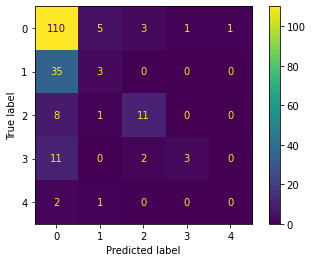

In [11]:
cm = confusion_matrix(y_val, KN_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

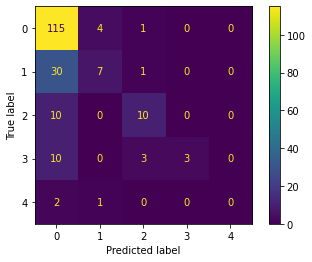

In [12]:
cm = confusion_matrix(y_val, KN_opt_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()